In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib
import h5py
import pandas as pd
from PIL import Image
from tqdm import tqdm_notebook as tqdm_loop
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../pytorch-cifar/models/")
from resnet import ResNet18

In [8]:
model = ResNet18()
s_dict = torch.load("output/final.checkpoint")["model_state_dict"]
model.load_state_dict(s_dict)

<All keys matched successfully>

In [9]:
torch.save({"net": s_dict}, "../Robust_Explanations/notebooks/models/RN18_SSR.pth")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.eval().to(device)

In [11]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#
cifar_test = torchvision.datasets.CIFAR10(root="../Robust_Explanations/notebooks/data/", train=False, download=True, 
                                          transform=transform_test)
#
test_loader = torch.utils.data.DataLoader(
        cifar_test,
        batch_size=32,
        shuffle=False
    )

Files already downloaded and verified


In [12]:
def accuracy(predicted_logits, reference):
    """Compute the ratio of correctly predicted labels"""
    labels = torch.argmax(predicted_logits, 1)
    correct_predictions = labels.eq(reference)
    return correct_predictions.sum().float() / correct_predictions.nelement()

criterion = torch.nn.CrossEntropyLoss()

test_losses = []
test_accs = []
weights_for_avg = []
with torch.no_grad():
    for batch_x, batch_y in tqdm_loop(test_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        prediction = model(batch_x)
        loss = criterion(prediction, batch_y)
        acc = accuracy(prediction, batch_y)
        test_accs.append(acc)
        test_losses.append(loss)
        weights_for_avg.append(len(batch_x))
        del batch_x
        del batch_y
        torch.cuda.empty_cache()

/home/ubuntu/anaconda3/envs/pytorch19_p37/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [13]:
np.average([i.cpu().item() for i in test_accs], weights=weights_for_avg)

0.853

#### explanation

In [9]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient
from captum.attr import visualization as viz

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
idx=10
img = images[idx].unsqueeze(dim=0).cuda()
img_label = labels[idx]

In [13]:
def torch_to_image(tensor, mean=0, std=1):
    """
    Helper function to convert torch tensor containing input data into image.
    """
    if len(tensor.shape) == 4:
        img = tensor.permute(0, 2, 3, 1)

    img = img.contiguous().squeeze().detach().cpu().numpy()

    img = img * std.reshape(1, 1, 3) + mean.reshape(1, 1, 3)
    return np.clip(img, 0, 1)

In [11]:
sal = Saliency(model)

/home/ubuntu/anaconda3/envs/pytorch19_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Text(0.5, 1.0, 'SSR')

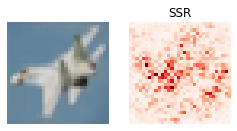

In [15]:
expl_ssr = sal.attribute(img, target=img_label)

fig, ax = plt.subplots(1,2, figsize=(4,2))
ax[0].imshow(torch_to_image(img, np.array([0.4914, 0.4822, 0.4465]), np.array([0.2023, 0.1994, 0.2010])))
viz.visualize_image_attr(np.transpose(expl_ssr.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)

for i in range(2):
    ax[i].axis('off')
ax[1].set_title("SSR")